# **1. Primeiro Tópico do Artigo (Geração das Matrizes)**

## **1.1. Fazer Globalmente**

### **1.1.1. Pré-processamento**

In [ ]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

dados_geograficos = gpd.read_file('/content/drive/MyDrive/MapBiomas/Cerrado_Agro_reprojetadoAlbers_Single_fix_centroides_Renomear_MediaDatas_2017a2022_Centroides.gpkg')


In [ ]:
def extract_first_part(value):
    if ',' in value:
        return value.split(',')[0]
    else:
        return value

dados_geograficos['STATE_NEW'] = dados_geograficos['STATE'].apply(extract_first_part)

dados_geograficos['CITY_NEW'] = dados_geograficos['CITY'].apply(extract_first_part)


In [ ]:
x = 'CITY_NEW'

# Contagem de observações para cada município
contagem_por_municipio = dados_geograficos[x].value_counts()

# Filtrar para municípios com mais de 3 observações
contagem_mais_de_3 = contagem_por_municipio[contagem_por_municipio >= 3]

# Obter a lista
lista_municipios = contagem_mais_de_3.index.tolist()

len(lista_municipios)

952

In [ ]:
ano = [2018,2019,2020,2021,2022]
estados = ['Maranhão', 'Tocantins', 'Goiás', 'Piauí', 'Minas Gerais', 'Mato Grosso', 'Bahia', 'Mato Grosso do Sul', 'Pará', 'Rondônia']

# Filtragem a ser utilizada

dados_geograficos_filtrados = dados_geograficos.query(
    "DETECTYE_1 == @ano and STATE_NEW == @estados and {} in @lista_municipios".format(x)
)

teste = dados_geograficos_filtrados['STATE_NEW'].value_counts()

teste

STATE_NEW
Maranhão              34988
Tocantins             18918
Goiás                 12757
Minas Gerais           9748
Mato Grosso            9374
Piauí                  9144
Bahia                  6176
Mato Grosso do Sul     4187
Pará                    355
Rondônia                236
Name: count, dtype: int64

In [ ]:
# realizar a contagem da lista de novo para pegar a filtragem

contagem_por_municipio = dados_geograficos_filtrados[x].value_counts()

contagem_mais_de_3 = contagem_por_municipio[contagem_por_municipio >= 3]

lista_municipios = contagem_mais_de_3.index.tolist()

print(len(lista_municipios), len(dados_geograficos_filtrados))


945 105883


### **1.1.2. Matrizes**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Armazenar os resultados da correlação aqui
resultados_correlacao = []

# Indo através dos municípios um por um
for municipio in lista_municipios:
    # Pegando apenas os dados do município atual
    dados_municipio = dados_geograficos_filtrados[dados_geograficos_filtrados[x] == municipio]

    # Calculando as distâncias entre os pontos deste município
    pontos = dados_municipio.geometry.apply(lambda ponto: [ponto.x, ponto.y]).tolist()
    distancias = cdist(pontos, pontos)

    # Calculando as diferenças de área entre os polígonos neste município
    areas = dados_municipio['AreaAlerta'].tolist()
    num_poligonos = len(areas)
    matriz_diferencas = np.zeros((num_poligonos, num_poligonos), dtype='float16')
    matriz_diferencas[:] = np.nan
    for i in range(num_poligonos):
        for j in range(i):
            area_i = areas[i]
            area_j = areas[j]
            diferenca_area = abs(area_i - area_j)
            matriz_diferencas[i][j] = diferenca_area

    # Transformando a coluna 'DETECTAT' em data
    dados_municipio['MEAN_DATE'] = pd.to_datetime(dados_municipio['MEAN_DATE'])

    # Calculando as diferenças de dias entre todas as datas
    datas = dados_municipio['MEAN_DATE'].tolist()
    num_datas_totais = len(datas)
    matriz_diferencas_datas = np.zeros((num_datas_totais, num_datas_totais), dtype='float16')
    matriz_diferencas_datas[:] = np.nan
    for i in range(num_datas_totais):
        for j in range(i):
            diferenca_dias = abs((datas[i] - datas[j]).days)
            matriz_diferencas_datas[i][j] = diferenca_dias


    # Criando um DataFrame com distâncias e diferenças de área
    data = {'distancias': distancias.flatten(),
            'tamanhos': matriz_diferencas.flatten(),
            'diferenca_dias': matriz_diferencas_datas.flatten()}
    new_df = pd.DataFrame(data)
    new_df = new_df.dropna()

    # Convertendo as distâncias de metros para quilômetros
    new_df['distancias'] /= 1000

    # Calculando a correlação de Spearman entre distâncias e tamanhos
    spearman_corrDT, p_valorDT = spearmanr(new_df['distancias'], new_df['tamanhos'])
    spearman_corrDDa, p_valorDDa = spearmanr(new_df['distancias'], new_df['diferenca_dias'])
    spearman_corrDaT, p_valorDaT = spearmanr(new_df['diferenca_dias'], new_df['tamanhos'])

    # Calculando os graus de liberdade para a correlação
    graus_liberdade_corr = len(new_df) - 2

    # Adicionando os resultados à lista de correlação
    resultados_correlacao.append({'CITY_NEW': municipio,
                                  'CorrelacaoDT': spearman_corrDT, 'Valor_PDT': p_valorDT,
                                  'CorrelacaoDDa': spearman_corrDDa, 'Valor_PDDa': p_valorDDa,
                                  'CorrelacaoDaT': spearman_corrDaT, 'Valor_PDaT': p_valorDaT,
                                  'Graus_Liberdade_Corr': graus_liberdade_corr})

# DataFrame com os resultados de correlação
resultados_correlacao_df = pd.DataFrame(resultados_correlacao)

resultados_correlacao_df


,CITY_NEW,CorrelacaoDT,Valor_PDT,CorrelacaoDDa,Valor_PDDa,CorrelacaoDaT,Valor_PDaT,Graus_Liberdade_Corr
0,Codó,-0.009968,8.711968e-17,-0.002802,1.934834e-02,0.217592,0.000000e+00,696788
1,Araioses,-0.015358,1.703557e-33,0.038927,2.356630e-205,0.008640,1.161106e-11,616603
2,Balsas,0.102483,0.000000e+00,0.057269,0.000000e+00,0.116631,0.000000e+00,564451
3,Grajaú,-0.035093,4.798059e-149,0.053017,0.000000e+00,0.003856,4.287913e-03,548626
4,Paranã,-0.004973,3.802813e-04,0.030331,3.355474e-104,0.195920,0.000000e+00,510553
...,...,...,...,...,...,...,...,...
940,Edealina,1.000000,0.000000e+00,-0.500000,6.666667e-01,-0.500000,6.666667e-01,1
941,Boquira,0.500000,6.666667e-01,0.866025,3.333333e-01,0.866025,3.333333e-01,1
942,Capitólio,1.000000,0.000000e+00,0.866025,3.333333e-01,0.866025,3.333333e-01,1
943,Turvelândia,0.500000,6.666667e-01,-1.000000,0.000000e+00,-0.500000,6.666667e-01,1


In [ ]:
filtro1 = 'STATE_NEW'

# Mesclar com as áreas
resultados_correlacao_df_com_UF = pd.merge(resultados_correlacao_df, dados_geograficos_filtrados[['CITY_NEW', filtro1]], on='CITY_NEW', how='left')

resultados_correlacao_df_com_UF = df_unique = resultados_correlacao_df_com_UF.drop_duplicates()

resultados_correlacao_df_com_UF.head(5)

,CITY_NEW,CorrelacaoDT,Valor_PDT,CorrelacaoDDa,Valor_PDDa,CorrelacaoDaT,Valor_PDaT,Graus_Liberdade_Corr,STATE_NEW
0,Codó,-0.009968,8.711968e-17,-0.002802,1.934834e-02,0.217592,0.000000e+00,696788,Maranhão
1181,Araioses,-0.015358,1.703557e-33,0.038927,2.356630e-205,0.008640,1.161106e-11,616603,Maranhão
2292,Balsas,0.102483,0.000000e+00,0.057269,0.000000e+00,0.116631,0.000000e+00,564451,Maranhão
3355,Grajaú,-0.035093,4.798059e-149,0.053017,0.000000e+00,0.003856,4.287913e-03,548626,Maranhão
4403,Paranã,-0.004973,3.802813e-04,0.030331,3.355474e-104,0.195920,0.000000e+00,510553,Tocantins


In [ ]:
# Renomear
resultados_correlacao_df_com_UF = resultados_correlacao_df_com_UF.rename(columns={'STATE_NEW': 'Estado'})
resultados_correlacao_df_com_UF

,CITY_NEW,CorrelacaoDT,Valor_PDT,CorrelacaoDDa,Valor_PDDa,CorrelacaoDaT,Valor_PDaT,Graus_Liberdade_Corr,Estado
0,Codó,-0.009968,8.711968e-17,-0.002802,1.934834e-02,0.217592,0.000000e+00,696788,Maranhão
1181,Araioses,-0.015358,1.703557e-33,0.038927,2.356630e-205,0.008640,1.161106e-11,616603,Maranhão
2292,Balsas,0.102483,0.000000e+00,0.057269,0.000000e+00,0.116631,0.000000e+00,564451,Maranhão
3355,Grajaú,-0.035093,4.798059e-149,0.053017,0.000000e+00,0.003856,4.287913e-03,548626,Maranhão
4403,Paranã,-0.004973,3.802813e-04,0.030331,3.355474e-104,0.195920,0.000000e+00,510553,Tocantins
...,...,...,...,...,...,...,...,...,...
105868,Edealina,1.000000,0.000000e+00,-0.500000,6.666667e-01,-0.500000,6.666667e-01,1,Goiás
105871,Boquira,0.500000,6.666667e-01,0.866025,3.333333e-01,0.866025,3.333333e-01,1,Bahia
105874,Capitólio,1.000000,0.000000e+00,0.866025,3.333333e-01,0.866025,3.333333e-01,1,Minas Gerais
105877,Turvelândia,0.500000,6.666667e-01,-1.000000,0.000000e+00,-0.500000,6.666667e-01,1,Goiás


### **1.1.3. As métricas**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

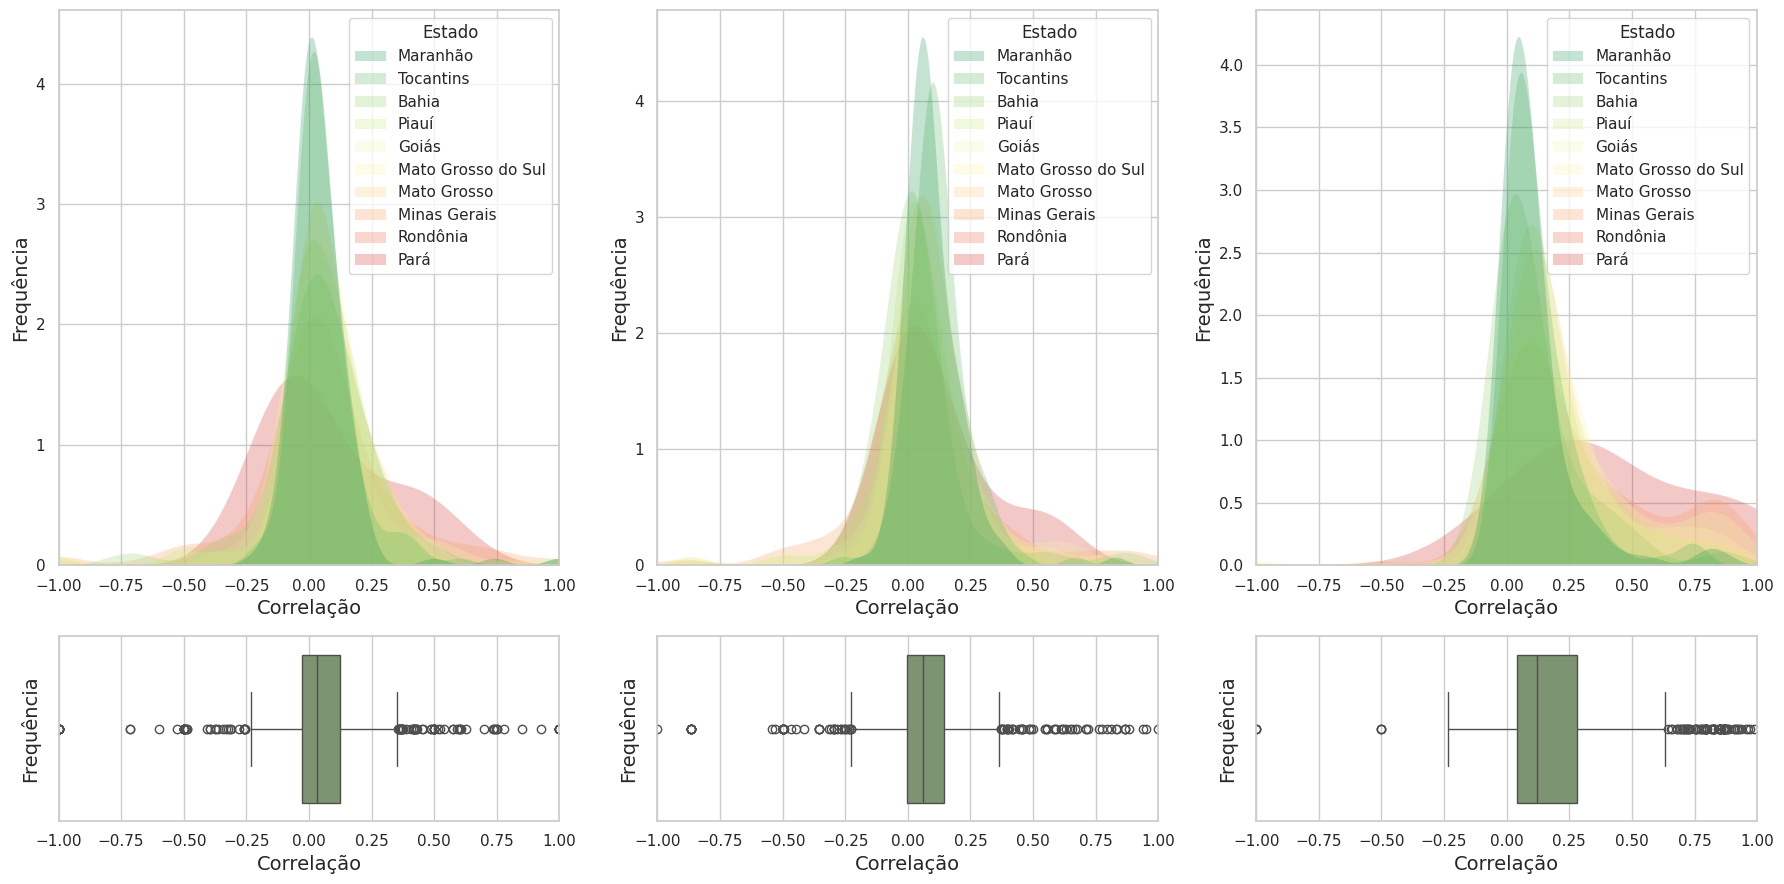

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Vamos ignorar os avisos
import warnings
warnings.filterwarnings("ignore")

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Aqui eu tenho que criar a figura e os subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9), gridspec_kw={'height_ratios': [3, 1]})

# Lista de variáveis x
x_vars = ['CorrelacaoDT', 'CorrelacaoDaT', 'CorrelacaoDDa']

# Definindo a faixa de valores desejada
limite_inferior = -1
limite_superior = 1

# Iterando sobre as variáveis x
for i, x_var in enumerate(x_vars):
    # Lembrar que nesta parte eu tenho que inverter manualmente a paleta "mako"
    paleta_mako_invertida = sns.color_palette('RdYlGn', n_colors=len(resultados_correlacao_df_com_UF['Estado'].unique()))
    paleta_mako_invertida.reverse()

    # Aqui eu tenho que plotar o KDE plot
    sns.kdeplot(
        data=resultados_correlacao_df_com_UF,
        x=x_var,
        hue="Estado",
        fill=True,
        common_norm=False,
        palette=paleta_mako_invertida,
        alpha=0.25,
        linewidth=0,
        ax=axes[0, i]  # Selecionando o subplot correto na primeira linha
    )

    # Definindo os limites dos eixos x do KDE plot
    axes[0, i].set_xlim(limite_inferior, limite_superior)

    # Adicionando rótulos e título
    axes[0, i].set_xlabel('Correlação',fontsize=14)
    axes[0, i].set_ylabel('Frequência',fontsize=14)
    #axes[0, i].set_title(f'Distribuição de {x_var} por Estado')

    # Aqui eu tenho que plotar o box plot
    sns.boxplot(
        data=resultados_correlacao_df_com_UF,
        x=x_var,
        ax=axes[1, i],  # Selecionando o subplot correto na segunda linha
        color="#7A9A69"
    )

    # Definindo os limites dos eixos x do box plot
    axes[1, i].set_xlim(limite_inferior, limite_superior)

    # Adicionando rótulos e título
    axes[1, i].set_xlabel('Correlação',fontsize=14)
    axes[1, i].set_ylabel('Frequência',fontsize=14)
    #axes[1, i].set_title(f'Boxplot de {x_var}')

# Ajustes de layout
plt.tight_layout()

# Salvar a figura
plt.savefig('Dispersograma_Box2.png', dpi=300)

# Fazer o download do arquivo
files.download('Dispersograma_Box2.png')

plt.show()


In [ ]:
import pandas as pd

# Dados para os três conjuntos de dados
dados_DT = resultados_correlacao_df_com_UF['CorrelacaoDT']
dados_DDa = resultados_correlacao_df_com_UF['CorrelacaoDDa']
dados_DaT = resultados_correlacao_df_com_UF['CorrelacaoDaT']

# Função para calcular os quartis
def calcular_quartis(dados):
    q1 = dados.quantile(0.25)
    q3 = dados.quantile(0.75)
    return q1, q3

# Calcula os quartis para os três conjuntos de dados
q1_DT, q3_DT = calcular_quartis(dados_DT)
q1_DDa, q3_DDa = calcular_quartis(dados_DDa)
q1_DaT, q3_DaT = calcular_quartis(dados_DaT)

# Exibe os quartis
print("Quartis para CorrelacaoDT:")
print("Q1:", q1_DT)
print("Q3:", q3_DT)

print("\nQuartis para CorrelacaoDDa:")
print("Q1:", q1_DDa)
print("Q3:", q3_DDa)

print("\nQuartis para CorrelacaoDaT:")
print("Q1:", q1_DaT)
print("Q3:", q3_DaT)


Quartis para CorrelacaoDT:
Q1: -0.02630093009130819
Q3: 0.12479405684036499

Quartis para CorrelacaoDDa:
Q1: 0.042543545845734526
Q3: 0.28033330330283696

Quartis para CorrelacaoDaT:
Q1: -0.004373254512914455
Q3: 0.1437371476625908


### **1.1.4. Amostragem para não estourar a memória**

In [ ]:
# Amostragem estratificada por estado
dados_geograficos_filtrados_estratificados = dados_geograficos_filtrados.groupby('STATE_NEW', group_keys=False).apply(lambda x: x.sample(min(len(x), 600), random_state=42))

# Verificar
print(dados_geograficos_filtrados_estratificados.shape)


(5391, 63)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist

# Aqui eu tenho que calcular as distâncias entre os pontos de todos os municípios
pontos_totais = dados_geograficos_filtrados_estratificados.geometry.apply(lambda ponto: [ponto.x, ponto.y]).tolist()
distancias_totais = cdist(pontos_totais, pontos_totais)

# Aqui eu tenho que calcular as diferenças de área entre todos os polígonos
areas_totais = dados_geograficos_filtrados_estratificados['ALERTHA'].tolist()
num_poligonos_totais = len(areas_totais)
matriz_diferencas_totais = np.zeros((num_poligonos_totais, num_poligonos_totais), dtype='float16')
matriz_diferencas_totais[:] = np.nan
for i in range(num_poligonos_totais):
    for j in range(i):
        area_i = areas_totais[i]
        area_j = areas_totais[j]
        diferenca_area = abs(area_i - area_j)
        matriz_diferencas_totais[i][j] = diferenca_area

# Converter a coluna 'DETECTAT' para o formato de data
dados_geograficos_filtrados_estratificados['MEAN_DATE'] = pd.to_datetime(dados_geograficos_filtrados_estratificados['MEAN_DATE'])

# Diferenças de dias entre todas as datas
datas_totais = dados_geograficos_filtrados_estratificados['MEAN_DATE'].tolist()
num_datas_totais = len(datas_totais)
matriz_diferencas_datas = np.zeros((num_datas_totais, num_datas_totais), dtype='float16')
matriz_diferencas_datas[:] = np.nan
for i in range(num_datas_totais):
    for j in range(i):
        diferenca_dias = abs((datas_totais[i] - datas_totais[j]).days)
        matriz_diferencas_datas[i][j] = diferenca_dias

# Criar DataFrame com distâncias, diferenças de área e diferenças de dias
data_totais = {'distancias': distancias_totais.flatten(),
               'tamanhos': matriz_diferencas_totais.flatten(),
               'diferenca_dias': matriz_diferencas_datas.flatten()}
new_df_totais = pd.DataFrame(data_totais)
new_df_totais = new_df_totais.dropna()

# Dividir as distâncias por 1000 para converter de metros para quilômetros
new_df_totais['distancias'] /= 1000

new_df_totais.head(10)


,distancias,tamanhos,diferenca_dias
5391,194.195758,14.484375,873.0
10782,247.310102,15.156250,205.0
10783,105.455830,0.668457,1078.0
16173,43.308648,20.734375,36.0
16174,206.324245,6.246094,909.0
16175,274.007478,5.578125,169.0
21564,184.426531,19.812500,226.0
21565,355.281167,5.320312,647.0
21566,366.760094,4.652344,431.0
21567,209.609388,0.924805,262.0


In [ ]:
import pandas as pd

# Dados para os três conjuntos de dados
dados_Dist = new_df_totais['distancias']
dados_Tama = new_df_totais['tamanhos']
dados_Dias = new_df_totais['diferenca_dias']

# Função para calcular os quartis
def calcular_quartis(dados):
    q1 = dados.quantile(0.25)
    q3 = dados.quantile(0.75)
    return q1, q3

# Os três conjuntos de dados
q1_DTamanhos, q3_DTamanhos = calcular_quartis(dados_Tama)
q1_Distancia, q3_Distancia = calcular_quartis(dados_Dist)
q1_Dias, q3_Dias = calcular_quartis(dados_Dias)

# Exibe
print("Quartis para Tamanhos:")
print("Q1:", q1_DTamanhos)
print("Q3:", q3_DTamanhos)

print("\nQuartis para Espacial:")
print("Q1:", q1_Distancia)
print("Q3:", q3_Distancia)

print("\nQuartis para Dias:")
print("Q1:", q1_Dias)
print("Q3:", q3_Dias)


Quartis para Tamanhos:
Q1: 7.57421875
Q3: 84.9375

Quartis para Espacial:
Q1: 538.2272605337903
Q3: 1283.0403430529816

Quartis para Dias:
Q1: 187.0
Q3: 812.0


KeyboardInterrupt: 

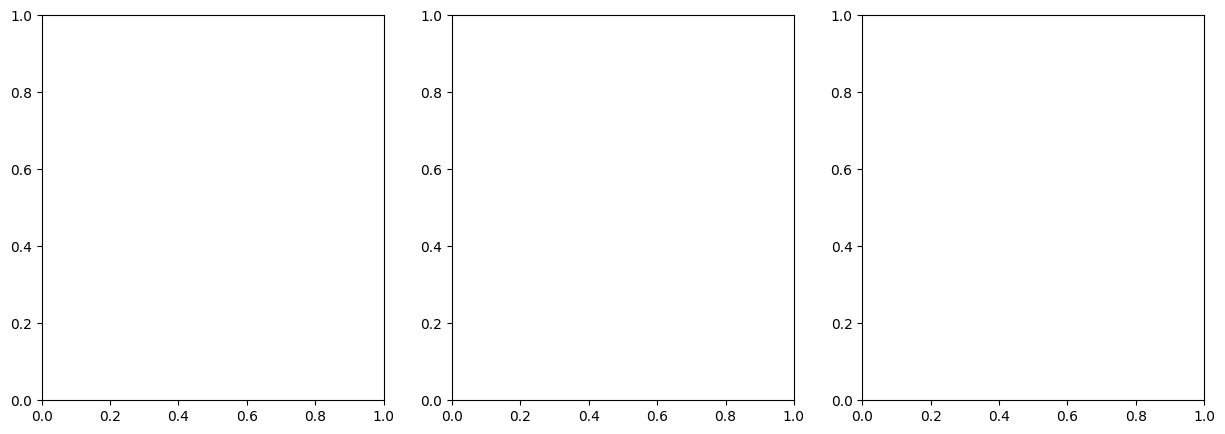

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Configurar o estilo
plt.style.use('default')

# Configurar a estrutura da figura
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Histograma bidimensional I: "distancias" no eixo x e "tamanhos" no eixo y
sns.histplot(x='distancias', y='tamanhos', data=new_df_totais, bins=40, discrete=(False, False), cbar=True, cbar_kws=dict(shrink=.75), ax=axs[0],color = '#93ae84')
axs[0].set_xlabel('Distância espacial (km)', fontsize=14)
axs[0].set_ylabel('Diferença de tamanho (ha)', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=11)

# Histograma bidimensional II: "diferenca_dias" no eixo x e "tamanhos" no eixo y
sns.histplot(x='diferenca_dias', y='tamanhos', data=new_df_totais, bins=40, discrete=(False, False), cbar=True, cbar_kws=dict(shrink=.75), ax=axs[1], color = '#93ae84')
axs[1].set_xlabel('Distância temporal (dias)', fontsize=14)
axs[1].set_ylabel('Diferença de tamanho (ha)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=11)

# Histograma bidimensional III: "diferenca_dias" no eixo x e "distancias" no eixo y
sns.histplot(x='diferenca_dias', y='distancias', data=new_df_totais, bins=40, discrete=(False, False),  cbar=True, cbar_kws=dict(shrink=.75), ax=axs[2],color = '#93ae84')
axs[2].set_xlabel('Distância temporal (dias)', fontsize=14)
axs[2].set_ylabel('Distância espacial (km)', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=11)

# Ajustes de layout
plt.tight_layout()

# Salvar a figura
plt.savefig('histogramas_bidimensionais2.png', dpi=300)

# Fazer o download do arquivo
files.download('histogramas_bidimensionais2.png')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from google.colab import files

# Os dados
dados_tamanhos = new_df_totais['tamanhos']
dados_distancias = new_df_totais['distancias']
dados_diferenca_dias = new_df_totais['diferenca_dias']

# Criar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# QQplot para os dados de tamanhos
stats.probplot(dados_tamanhos, dist="norm", rvalue='True', plot=axs[0])
axs[0].set_xlabel('Quartis Teóricos', fontsize=14)
axs[0].set_ylabel('Diferença de tamanho (ha)', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=11)
axs[0].tick_params(axis='both', which='major', width=0.5)  # Espessura da grade

# QQplot para os dados de distancias
stats.probplot(dados_distancias, dist="norm", rvalue='True', plot=axs[1])
axs[1].set_xlabel('Quartis Teóricos', fontsize=14)
axs[1].set_ylabel('Distância espacial (km)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[1].tick_params(axis='both', which='major', width=0.5)  # Espessura da grade

# QQplot para os dados de diferenca_dias
stats.probplot(dados_diferenca_dias, dist="norm", rvalue='True', plot=axs[2])
axs[2].set_xlabel('Quartis Teóricos', fontsize=14)
axs[2].set_ylabel('Distância temporal (dias)', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=11)
axs[2].tick_params(axis='both', which='major', width=0.5)  # Espessura da grade

# Ajustar layout
plt.tight_layout()

# Salvar a figura
plt.savefig('histogramas_bidimensionais2.png', dpi=300)

# Fazer o download do arquivo
files.download('histogramas_bidimensionais2.png')

# Exibir o gráfico
plt.show()


## **1.2. Municipal**

### **1.2.1. Pré**

In [ ]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

dados_geograficos = gpd.read_file('/content/drive/MyDrive/MapBiomas/Cerrado_Agro_reprojetadoAlbers_Single_fix_centroides_Renomear_MediaDatas_2017a2022_Centroides_CAR.gpkg')

In [ ]:
# Definindo uma função para realizar a divisão
def realizar_divisao(row):
    # Aqui eu tenho que verificar se o divisor não é zero para evitar divisão por zero
    if row['AreaAlerta'] != 0:
        return row['New_AreaAlerta'] / row['AreaAlerta']
    else:
        return None

# Aplicando a função para cada linha do DataFrame
dados_geograficos['divisao'] = dados_geograficos.apply(realizar_divisao, axis=1)

# Definindo uma função para aplicar a lógica de filtragem
def aplicar_filtragem(row):
    # Aqui eu tenho que verificar se o valor de 'CAR' é 1 e se a divisão é maior que 0.1
    if row['CAR'] == 1 and row['divisao'] > 0.1:
        return 1
    else:
        return 0

# Aplicando a função de filtragem para criar a nova coluna
dados_geograficos['CAR2'] = dados_geograficos.apply(aplicar_filtragem, axis=1)

dados_geograficos.head(20)


,NEW_ALERTC,AreaAlerta,MEAN_DATE,DETECTYE_1,CITY_NEW,STATE_NEW,CAR,New_AreaAlerta,geometry,divisao,CAR2
0,961413,3.000,2022/10/11 00:00:00.000,2022,Chapada Gaúcha,Minas Gerais,1,2.999615,POINT (1478425.744 1897450.395),0.999872,1
1,976325,2.104,2021/09/22 00:00:00.000,2021,São Francisco do Maranhão,Maranhão,1,2.103917,POINT (1851114.377 2857408.064),0.999961,1
2,919355,4.592,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,4.591662,POINT (1311237.887 1931274.182),0.999926,1
3,919355a,1.384,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,1.383850,POINT (1311136.694 1930658.769),0.999892,1
4,919355b,5.894,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,5.893814,POINT (1309896.574 1930091.316),0.999968,1
5,919355c,4.773,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,4.772823,POINT (1309852.297 1930679.557),0.999963,1
6,919355d,2.712,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,2.711719,POINT (1310632.963 1930869.992),0.999897,1
7,919355e,17.397,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,17.397382,POINT (1310477.791 1931167.529),1.000022,1
8,919355f,3.231,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,3.230726,POINT (1310303.095 1930575.573),0.999915,1
9,919355g,1.924,2022/10/16 00:00:00.000,2022,Formosa,Goiás,1,1.923596,POINT (1309789.956 1930238.393),0.999790,1


In [ ]:
estados = ['Maranhão', 'Tocantins', 'Goiás', 'Piauí', 'Minas Gerais', 'Mato Grosso', 'Bahia', 'Mato Grosso do Sul', 'Pará', 'Rondônia']

teste = dados_geograficos.query( #MUDAR AQUI QUANDO COLOCAR O GERAL
        "STATE_NEW in @estados"
)

x= 'CITY_NEW'
contagem = teste[x].value_counts()
contagem_filtrada = contagem[contagem >= 3]
contagem_filtrada

CITY_NEW
Codó             1181
Araioses         1111
Balsas           1063
Grajaú           1048
Paranã           1011
                 ... 
Sanclerlândia       3
Bacabal             3
Glaucilândia        3
Itumbiara           3
Nova Aurora         3
Name: count, Length: 945, dtype: int64

### **1.2.2. Gerando as Matrizes**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Definindo os diferentes conjuntos de anos
years = [[2018, 2019], [2018, 2019, 2020], [2018, 2019, 2020, 2021], [2018, 2019, 2020, 2021, 2022]]

# Inicializando uma lista para armazenar os DataFrames de correlação
dfs_correlacao = []

# Iterando sobre os conjuntos de anos
for index, year_set in enumerate(years):
    resultados_correlacao = []

    x = 'CITY_NEW'

    # Contagem de observações para cada município
    contagem_por_municipio = dados_geograficos[x].value_counts()

    # Filtrando para municípios com mais de 3 observações
    contagem_mais_de_3 = contagem_por_municipio[contagem_por_municipio >= 3]

    # Obtendo a lista de municípios com mais de 3 observações
    lista_municipios = contagem_mais_de_3.index.tolist()


    """
    # AQUI VAI A FILTRAGEM:

    # Criando uma cópia dos dados apenas para os municípios da lista_municipios
    dados_filtrados = dados_geograficos[dados_geograficos[x].isin(lista_municipios)].copy()

    # Função para filtrar os 10% maiores alertas para cada município
    def filter_top_10_percent(group):
        top_10_percent = group['AreaAlerta'].quantile(0.1)  # Calculando o valor correspondente aos 10% maiores alertas
        return group[group['AreaAlerta'] >= top_10_percent]

    # Aplicando a função de filtragem para cada grupo de município
    dados_filtrados = dados_filtrados.groupby(x).apply(filter_top_10_percent).reset_index(drop=True)

    # AQUI TERMINA A PRIMEIRA PARTE
    """


    estados = ['Maranhão', 'Tocantins', 'Goiás', 'Piauí', 'Minas Gerais', 'Mato Grosso', 'Bahia', 'Mato Grosso do Sul', 'Pará', 'Rondônia']
    unidades_filtradas = lista_municipios

    filtered_data = dados_geograficos.query( # MUDAR AQUI QUANDO COLOCAR O GERAL
        "DETECTYE_1 == @year_set and STATE_NEW in @estados and {} in @unidades_filtradas and CAR2 == 1".format(x)
    )

    # Contagem de observações para cada município
    contagem_por_municipio = filtered_data[x].value_counts()

    # Filtrando para municípios com mais de 3 observações
    contagem_mais_de_3 = contagem_por_municipio[contagem_por_municipio >= 3]

    # A lista com mais de três
    lista_municipios = contagem_mais_de_3.index.tolist()

    print(len(lista_municipios), len(filtered_data))

    # Iterando sobre os municípios
    for municipio in lista_municipios:
        # Filtrando os dados relevantes para o município atual
        dados_municipio = filtered_data[filtered_data[x] == municipio]

        # Calculando as distâncias entre os pontos do município atual
        pontos = dados_municipio.geometry.apply(lambda ponto: [ponto.x, ponto.y]).tolist()
        distancias = cdist(pontos, pontos)

        # Calculando as diferenças de área entre os polígonos do município atual
        areas = dados_municipio['AreaAlerta'].tolist()
        num_poligonos = len(areas)
        matriz_diferencas = np.zeros((num_poligonos, num_poligonos), dtype='float16')
        matriz_diferencas[:] = np.nan
        for i in range(num_poligonos):
            for j in range(i):
                area_i = areas[i]
                area_j = areas[j]
                diferenca_area = abs(area_i - area_j)
                matriz_diferencas[i][j] = diferenca_area

        # Convertendo a coluna 'DETECTAT' para o formato de data
        dados_municipio['MEAN_DATE'] = pd.to_datetime(dados_municipio['MEAN_DATE'])

        # Calculando as diferenças de dias entre todas as datas
        datas = dados_municipio['MEAN_DATE'].tolist()
        num_datas_totais = len(datas)
        matriz_diferencas_datas = np.zeros((num_datas_totais, num_datas_totais), dtype='float16')
        matriz_diferencas_datas[:] = np.nan
        for i in range(num_datas_totais):
            for j in range(i):
                diferenca_dias = abs((datas[i] - datas[j]).days)
                matriz_diferencas_datas[i][j] = diferenca_dias


        # Criando DataFrame com distâncias e diferenças de área
        data = {'distancias': distancias.flatten(),
                'tamanhos': matriz_diferencas.flatten(),
                'diferenca_dias': matriz_diferencas_datas.flatten()}
        new_df = pd.DataFrame(data)
        new_df = new_df.dropna()

        # Dividindo as distâncias por 1000 para converter de metros para quilômetros
        new_df['distancias'] /= 1000

        '''
        new_df = new_df.query(
            "tamanhos > 250"
        )
        '''

        # Calculando correlação de Spearman entre distâncias e tamanhos
        spearman_corrDT, p_valorDT = spearmanr(new_df['distancias'], new_df['tamanhos'])
        spearman_corrDDa, p_valorDDa = spearmanr(new_df['distancias'], new_df['diferenca_dias'])
        spearman_corrDaT, p_valorDaT = spearmanr(new_df['diferenca_dias'], new_df['tamanhos'])

        # Calculando os graus de liberdade para a correlação
        graus_liberdade_corr = len(new_df) - 2

        # Adicionando os resultados à lista de resultados de correlação
        resultados_correlacao.append({'CITY': municipio,
                                    'CorrelacaoDT': spearman_corrDT, 'Valor_PDT': p_valorDT,
                                    'CorrelacaoDDa': spearman_corrDDa, 'Valor_PDDa': p_valorDDa,
                                    'CorrelacaoDaT': spearman_corrDaT, 'Valor_PDaT': p_valorDaT,
                                    'Graus_Liberdade_Corr': graus_liberdade_corr,})

    # Criando DataFrame a partir da lista de resultados de correlação
    resultados_correlacao_df = pd.DataFrame(resultados_correlacao)

    # Exibindo os resultados
    dfs_correlacao.append(resultados_correlacao_df)


# Em cada posição da lista dfs_correlacao
correlacao_ano_1 = dfs_correlacao[0]
correlacao_ano_2 = dfs_correlacao[1]
correlacao_ano_3 = dfs_correlacao[2]
correlacao_ano_4 = dfs_correlacao[3]


692 31145
861 62331
887 73826
918 89377


### **1.2.3. Tabelas para o art**

In [ ]:
import pandas as pd
from scipy.stats import chi2

# Lista de colunas a serem analisadas
lista = ['CorrelacaoDT', 'CorrelacaoDaT', 'CorrelacaoDDa']

# Inicializar uma lista para armazenar todos os DataFrames de resultados
resultados_dfs = []

# Iterar sobre as colunas
for a in lista:
    # Inicializar uma lista para armazenar os resultados de percentuais
    percentuais = []

    # Iterar sobre os DataFrames de correlação
    for correlacao_ano in [correlacao_ano_1, correlacao_ano_2, correlacao_ano_3, correlacao_ano_4]:
        # Filtrar as linhas com valores absolutos maiores que 0.6, "Graus_Liberdade_Corr" maior que 4 e p-valor mínimo
        if a == 'CorrelacaoDT':
            linhas_filtradas_abs = correlacao_ano[(correlacao_ano[a].abs() > 0.6) & (correlacao_ano['Graus_Liberdade_Corr'] > 4) & (correlacao_ano['Valor_PDT'] < 0.05) & (~correlacao_ano[a].isna())]
        elif a == 'CorrelacaoDDa':
            linhas_filtradas_abs = correlacao_ano[(correlacao_ano[a].abs() > 0.6) & (correlacao_ano['Graus_Liberdade_Corr'] > 4) & (correlacao_ano['Valor_PDDa'] < 0.05) & (~correlacao_ano[a].isna())]
        elif a == 'CorrelacaoDaT':
            linhas_filtradas_abs = correlacao_ano[(correlacao_ano[a].abs() > 0.6) & (correlacao_ano['Graus_Liberdade_Corr'] > 4) & (correlacao_ano['Valor_PDaT'] < 0.05) & (~correlacao_ano[a].isna())]

        # Calcular o percentual das linhas filtradas em relação ao total de linhas não NaN na coluna
        percentual_abs = (len(linhas_filtradas_abs) / len(correlacao_ano[a].dropna())) * 100

        # Adicionar o percentual à lista de resultados
        percentuais.append(percentual_abs)

    # Criar DataFrame com os resultados de percentuais para a coluna atual
    df_percentuais = pd.DataFrame({'Ano': ['Ano 1', 'Ano 2', 'Ano 3', 'Ano 4'], 'Percentual_Abs_Maior_0.6': percentuais})

    # Calcular a média de Percentual_Positivo
    mean_percentual_positivo = df_percentuais['Percentual_Abs_Maior_0.6'].mean()

    # Criar um DataFrame para os valores esperados (Ei)
    df_expected_values = pd.DataFrame({'Expected values (Ei)': mean_percentual_positivo}, index=df_percentuais.index)

    # Calcular (Oi - Ei)^2 / Ei para cada ano
    df_residuals = ((df_percentuais['Percentual_Abs_Maior_0.6'] - mean_percentual_positivo) ** 2 / mean_percentual_positivo).rename('(Oi - Ei)^2 / Ei')

    # Calcular a estatística qui-quadrado total
    chi2_statistic = df_residuals.sum()

    # Calcular os graus de liberdade (número de categorias - 1)
    degrees_of_freedom = len(df_percentuais) - 1

    # Calcular o valor crítico da distribuição qui-quadrado para um nível de significância de 0,05
    critical_value95 = chi2.ppf(0.95, degrees_of_freedom)
    critical_value99 = chi2.ppf(0.99, degrees_of_freedom)

    # Verificar se a estatística qui-quadrado excede o valor crítico
    is_significant = chi2_statistic > critical_value95

    # Adicionar uma linha para a estatística qui-quadrado total
    df_residuals.loc['Total'] = df_residuals.sum()

    # Combinar todos os DataFrames em um único DataFrame
    df_combined = pd.concat([df_percentuais, df_expected_values, df_residuals], axis=1)

    # Adicionar o DataFrame combinado à lista de DataFrames de resultados
    resultados_dfs.append(df_combined)

    # Exibir o  combinado
    print(df_combined.to_string(decimal=','))
    print("\nEstatística qui-quadrado:", chi2_statistic)
    print("Graus de liberdade:", degrees_of_freedom)
    print("Valor crítico da distribuição qui-quadrado a 95%:", critical_value95)
    print("A estatística qui-quadrado é significativa ao nível de 0,05?", is_significant)
    print("Valor crítico da distribuição qui-quadrado a 99%:", critical_value99)
    print("\n-------------------------------------------------------------------------------\n")


         Ano  Percentual_Abs_Maior_0.6  Expected values (Ei)  (Oi - Ei)^2 / Ei
0      Ano 1                  2,312139              1,620519          0,295176
1      Ano 2                  1,509872              1,620519          0,007555
2      Ano 3                  1,352875              1,620519          0,044204
3      Ano 4                  1,307190              1,620519          0,060583
Total    NaN                       NaN                   NaN          0,407517

Estatística qui-quadrado: 0.40751719227546407
Graus de liberdade: 3
Valor crítico da distribuição qui-quadrado a 95%: 7.814727903251179
A estatística qui-quadrado é significativa ao nível de 0,05? False
Valor crítico da distribuição qui-quadrado a 99%: 11.344866730144373

-------------------------------------------------------------------------------

         Ano  Percentual_Abs_Maior_0.6  Expected values (Ei)  (Oi - Ei)^2 / Ei
0      Ano 1                  1,203008              1,678831          0,134861
1      Ano 2 

In [ ]:
import pandas as pd
from scipy.stats import chi2

# Lista de colunas a serem analisadas
lista = ['CorrelacaoDT', 'CorrelacaoDaT', 'CorrelacaoDDa']

# Inicializar uma lista para armazenar todos os DataFrames de resultados
resultados_dfs = []

# Iterar sobre as colunas
for a in lista:
    # Listas para armazenar os dados de correlação filtrados de cada ano
    correlacoes_ano1 = []
    correlacoes_ano2 = []
    correlacoes_ano3 = []
    correlacoes_ano4 = []

    # Iterar sobre os DataFrames de correlação
    for correlacao_ano in [correlacao_ano_1, correlacao_ano_2, correlacao_ano_3, correlacao_ano_4]:
        # Filtrar as linhas com valores absolutos maiores que 0.6 e "Graus_Liberdade_Corr" maior que 4
        linhas_filtradas_abs = correlacao_ano[(correlacao_ano[a].abs() > 0.6) & (correlacao_ano['Graus_Liberdade_Corr'] > 4) & (correlacao_ano['Valor_PDT'] < 0.05) & (~correlacao_ano[a].isna())]
        # Adicionar os valores filtrados à lista correspondente ao ano
        if a in linhas_filtradas_abs:
            if correlacao_ano is correlacao_ano_1:
                correlacoes_ano1.extend(linhas_filtradas_abs[a].tolist())
            elif correlacao_ano is correlacao_ano_2:
                correlacoes_ano2.extend(linhas_filtradas_abs[a].tolist())
            elif correlacao_ano is correlacao_ano_3:
                correlacoes_ano3.extend(linhas_filtradas_abs[a].tolist())
            elif correlacao_ano is correlacao_ano_4:
                correlacoes_ano4.extend(linhas_filtradas_abs[a].tolist())

    # Calcular a sobreposição percentual entre os anos

    # Para os anos 1 e 2
    total_ano1_ano2 = len(set(correlacoes_ano1).union(correlacoes_ano2))  # Total de valores únicos nos anos 1 e 2
    sobreposicao_ano1_ano2 = len(set(correlacoes_ano1).intersection(correlacoes_ano2))  # Número de valores sobrepostos
    percentual_sobreposicao_ano1_ano2 = (sobreposicao_ano1_ano2 / total_ano1_ano2) * 100

    # Para os anos 1, 2 e 3
    total_ano1_ano2_ano3 = len(set(correlacoes_ano1).union(correlacoes_ano2).union(correlacoes_ano3))  # Total de valores únicos nos anos 1, 2 e 3
    sobreposicao_ano1_ano2_ano3 = len(set(correlacoes_ano1).intersection(correlacoes_ano2).intersection(correlacoes_ano3))  # Número de valores sobrepostos
    percentual_sobreposicao_ano1_ano2_ano3 = (sobreposicao_ano1_ano2_ano3 / total_ano1_ano2_ano3) * 100

    # Para os anos 1, 2, 3 e 4
    total_ano1_ano2_ano3_ano4 = len(set(correlacoes_ano1).union(correlacoes_ano2).union(correlacoes_ano3).union(correlacoes_ano4))  # Total de valores únicos nos anos 1, 2, 3 e 4
    sobreposicao_ano1_ano2_ano3_ano4 = len(set(correlacoes_ano1).intersection(correlacoes_ano2).intersection(correlacoes_ano3).intersection(correlacoes_ano4))  # Número de valores sobrepostos
    percentual_sobreposicao_ano1_ano2_ano3_ano4 = (sobreposicao_ano1_ano2_ano3_ano4 / total_ano1_ano2_ano3_ano4) * 100

    # Mostrar os resultados
    print(f"Porcentagem de valores sobrepostos entre os anos 1 e 2: {percentual_sobreposicao_ano1_ano2:.2f}%")
    print(f"Porcentagem de valores sobrepostos entre os anos 1, 2 e 3: {percentual_sobreposicao_ano1_ano2_ano3:.2f}%")
    print(f"Porcentagem de valores sobrepostos entre os anos 1, 2, 3 e 4: {percentual_sobreposicao_ano1_ano2_ano3_ano4:.2f}%")
    print("\n---------------------------------------------------------------------\n")


Porcentagem de valores sobrepostos entre os anos 1 e 2: 11.54%
Porcentagem de valores sobrepostos entre os anos 1, 2 e 3: 3.23%
Porcentagem de valores sobrepostos entre os anos 1, 2, 3 e 4: 2.63%

---------------------------------------------------------------------

Porcentagem de valores sobrepostos entre os anos 1 e 2: 14.29%
Porcentagem de valores sobrepostos entre os anos 1, 2 e 3: 6.25%
Porcentagem de valores sobrepostos entre os anos 1, 2, 3 e 4: 5.00%

---------------------------------------------------------------------

Porcentagem de valores sobrepostos entre os anos 1 e 2: 3.57%
Porcentagem de valores sobrepostos entre os anos 1, 2 e 3: 1.49%
Porcentagem de valores sobrepostos entre os anos 1, 2, 3 e 4: 1.22%

---------------------------------------------------------------------



### **1.2.4. Gráfico de distribuição do GL**

In [ ]:
correlacao_ano_4.columns

Index(['CITY', 'CorrelacaoDT', 'Valor_PDT', 'CorrelacaoDDa', 'Valor_PDDa',
       'CorrelacaoDaT', 'Valor_PDaT', 'Graus_Liberdade_Corr'],
      dtype='object')

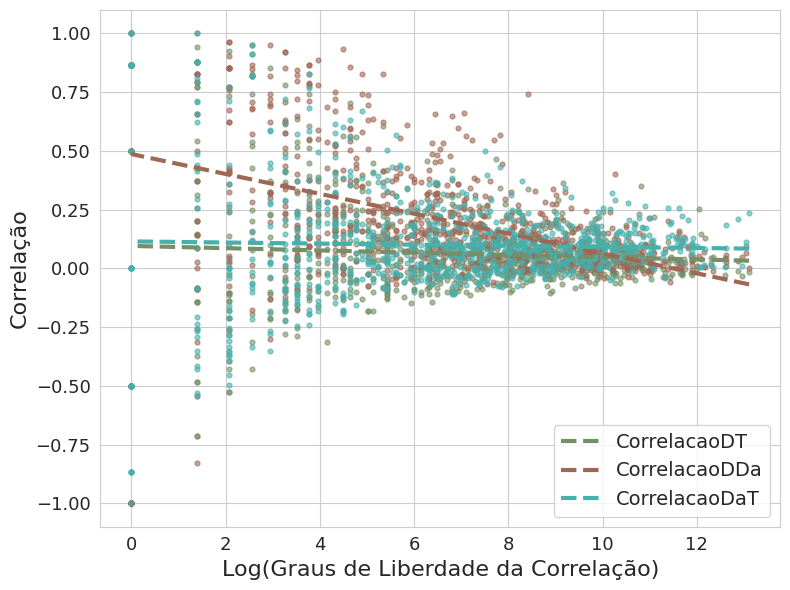

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.lines as mlines

# Supondo que você já tenha carregado o DataFrame correlacao_ano_4 e selecionado as colunas relevantes

# Remover linhas com valores NaN
correlacao_ano_4.dropna(subset=['CorrelacaoDT', 'CorrelacaoDDa', 'CorrelacaoDaT'], inplace=True)

# Definir as cores para cada variável
cores = ['#758f66', '#a06755', '#45b0ac']

# Aplicar transformação logarítmica apenas ao eixo x
x_log = np.log(correlacao_ano_4['Graus_Liberdade_Corr'])

# Tamanhos das bolinhas
tamanhos = 12

# Criar o scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

lines = []  # Lista para armazenar as linhas de legenda personalizada

for i, variavel in enumerate(['CorrelacaoDT', 'CorrelacaoDDa', 'CorrelacaoDaT']):
    y = correlacao_ano_4[variavel]

    ax.scatter(x_log, y, color=cores[i], alpha=0.6, s=tamanhos)

    # Calcular a tendência linear
    model = LinearRegression()
    model.fit(x_log.values.reshape(-1, 1), y)
    y_pred = model.predict(x_log.values.reshape(-1, 1))

    # Plotar a linha de tendência
    line = ax.plot(x_log, y_pred, color=cores[i], linestyle='--', linewidth=3, label=variavel)
    lines.append(line[0])

# Adicionar rótulos aos eixos
ax.set_xlabel('Log(Graus de Liberdade da Correlação)', fontsize=16)
ax.set_ylabel('Correlação', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=13)

legend = ax.legend(handles=lines, loc='lower right', fontsize=14)

# Ajustes de layout
plt.tight_layout()

plt.show()


# **2. Segundo tópico**

## **2.1. Comportamento Normal das variáveis**

In [ ]:
import pandas as pd

dados = pd.read_excel('/content/drive/MyDrive/MapBiomas/feito_para_probit2_mantidos2_binarizado_gdf.xlsx')

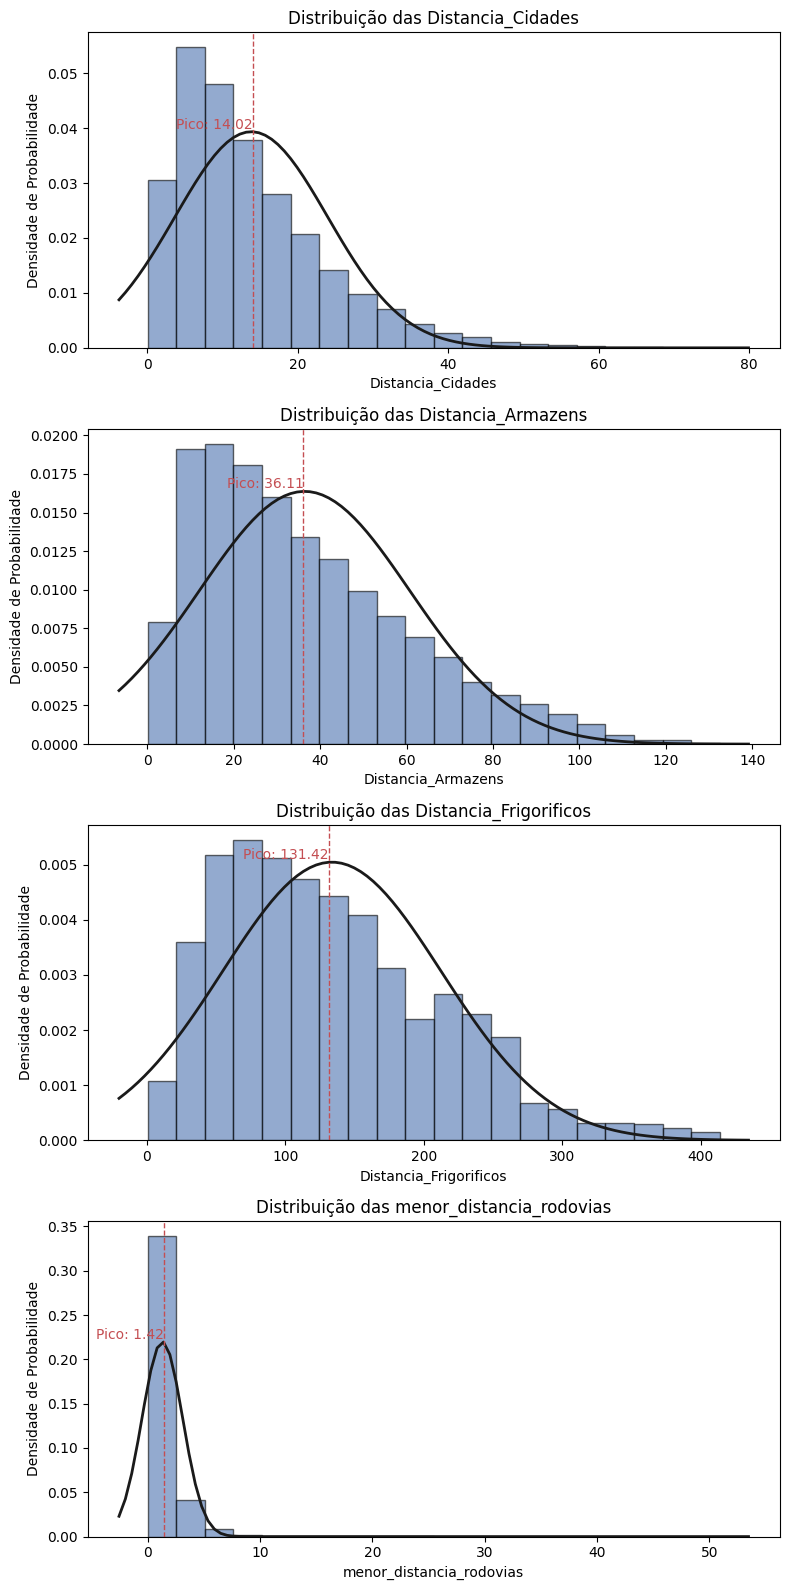

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Lista de variáveis de distância
distancias = ['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias']

# Configuração do subplot
fig, axs = plt.subplots(len(distancias), 1, figsize=(8, len(distancias)*4))

# Loop sobre as variáveis de distância
for i, distancia in enumerate(distancias):
    # Plotando o histograma das distâncias
    axs[i].hist(dados[distancia], bins=20, density=True, alpha=0.6, color='b', edgecolor='black')

    # Calculando os parâmetros da distribuição normal
    mu, std = norm.fit(dados[distancia])

    # A distribuição normal para cada
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axs[i].plot(x, p, 'k', linewidth=2)


    axs[i].set_title(f'Distribuição das {distancia}')
    axs[i].set_xlabel(f'{distancia}')
    axs[i].set_ylabel('Densidade de Probabilidade')

    # O ponto de pico da distribuição
    pico = x[np.argmax(p)]
    axs[i].axvline(pico, color='r', linestyle='--', linewidth=1)
    axs[i].text(pico, np.max(p), f'Pico: {pico:.2f}', color='r', verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()

plt.show()


## **2.2. Segmentando os valores para os meses**

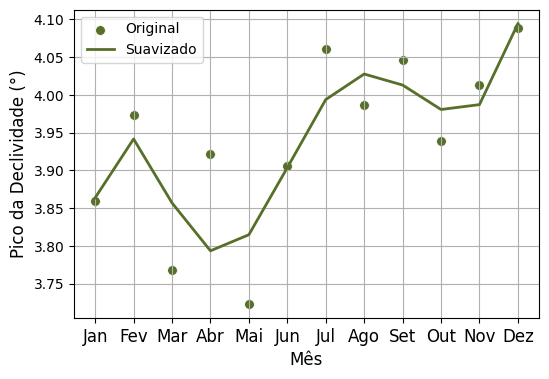

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.stats import norm

# Lista das variáveis de distância
lista = ['mean']

# Mapeamento dos nomes das variáveis de distância
nomes_variaveis = {
    'mean': 'Declividade',
}

# Converter a coluna 'MEAN_MONTH_TEXT' para o tipo datetime
dados['MEAN_MONTH_TEXT'] = pd.to_datetime(dados['MEAN_MONTH_TEXT'], format='%B')

# Extrair o mês de cada data
dados['Month'] = dados['MEAN_MONTH_TEXT'].dt.month

# Plotar um gráfico de pontos para cada variável de distância
for variavel in lista:
    # Inicializar uma lista para armazenar os picos de cada mês
    picos_por_mes = []

    # Loop sobre os meses
    for mes in range(1, 13):
        # Selecionar os dados para o mês atual
        dados_mes = dados[dados['Month'] == mes]

        # Ajustar uma distribuição normal aos dados do mês atual
        mu, std = norm.fit(dados_mes[variavel])

        # Adicionar o pico (mu) à lista de picos
        picos_por_mes.append(mu)

    # Criar um DataFrame com os picos de cada mês
    picos_por_mes_df = pd.DataFrame({'Month': range(1, 13), variavel: picos_por_mes})

    # Variáveis o gráfico
    plt.figure(figsize=(6, 4))

    # Plotar os pontos de dados originais
    sns.scatterplot(x='Month', y=variavel, data=picos_por_mes_df, color='#56702a', label='Original', s=50)

    # Suavizar apenas a linha utilizando Savitzky-Golay filter
    picos_por_mes_df[variavel + '_suavizado'] = savgol_filter(picos_por_mes_df[variavel], window_length=11, polyorder=6)

    # Plotar a linha suavizada
    sns.lineplot(x='Month', y=variavel + '_suavizado', data=picos_por_mes_df, marker='', color='#56702a', label='Suavizado', linewidth=2)

    plt.xlabel('Mês', fontsize=12)
    plt.ylabel(f'Pico da {nomes_variaveis[variavel]} (°)', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], fontsize=12)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.savefig(f'pico_{variavel}.png', dpi=300, bbox_inches='tight')  # Ajuste bbox_inches='tight'

    plt.show()


## **2.3. Tabela Ano x Estado**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Lista de anos considerados
anos = [2019, 2020, 2021, 2022]

# Lista de estados ordenados alfabeticamente
estados = sorted(dados['STATE_NEW'].unique())

# Lista de variáveis de interesse
variaveis = ['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias', 'mean']

# Criando um dicionário para armazenar as tabelas de valores de pico de cada variável
tabelas_valores_pico = {}

# Loop sobre as variáveis de interesse
for variavel in variaveis:
    # Criando uma tabela para armazenar os valores de pico da variável atual
    tabela_valores_pico = pd.DataFrame(index=anos, columns=estados)

    # Loop sobre os anos
    for ano in anos:
        # Loop sobre os estados
        for estado in estados:
            # Selecionando os dados para o ano e estado específicos
            dados_selecionados = dados[(dados['DETECTYE_1'] == ano) & (dados['STATE_NEW'] == estado)]

            # Calculando os parâmetros da distribuição normal
            mu, std = norm.fit(dados_selecionados[variavel])

            # Encontrando o ponto de pico da distribuição
            pico = mu

            # Armazenando o valor de pico na tabela
            tabela_valores_pico.loc[ano, estado] = pico

    # Adicionando a tabela de valores de pico ao dicionário
    tabelas_valores_pico[variavel] = tabela_valores_pico

# Exibindo as tabelas de valores de pico para cada variável
for variavel, tabela in tabelas_valores_pico.items():
    print(f'Tabela de valores de pico para {variavel}:')
    print(tabela)
    print()


Tabela de valores de pico para Distancia_Cidades:
          Bahia      Goiás   Maranhão Mato Grosso Mato Grosso do Sul  \
2019  18.261927   15.20226   9.999528   21.278328          24.545147   
2020  14.673361  14.357793   9.750397   20.074826          22.265907   
2021  15.783552  15.737777   8.669105   21.975126          23.309514   
2022  17.362685  15.089322  11.119824   21.125755          23.476591   

     Minas Gerais       Pará      Piauí   Rondônia  Tocantins  
2019    11.888195  17.256196  13.780213   32.81899  16.721283  
2020    11.092633   16.43308  11.827262  32.775965  15.099212  
2021    11.607019  17.253945  11.154643  32.863782  16.483488  
2022    10.920699  16.165614  12.359792  30.925647  15.211451  

Tabela de valores de pico para Distancia_Armazens:
          Bahia      Goiás   Maranhão Mato Grosso Mato Grosso do Sul  \
2019   31.44909  26.784969  46.182649   27.288379          38.222128   
2020  35.840212  27.913083  45.754287   24.582716          35.164365   
2

In [ ]:
lista = ['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias', 'mean']

# Suponha que você queira acessar a tabela de valores de pico para x
tabela_de_interesse = tabelas_valores_pico[lista[4]]  # Para 'Distancia_Cidades'

# Exibir a tabela de valores de pico para 'Distancia_Cidades'
tabela_de_interesse


,Bahia,Goiás,Maranhão,Mato Grosso,Mato Grosso do Sul,Minas Gerais,Pará,Piauí,Rondônia,Tocantins
2019,2.470382,5.195126,3.808741,3.813895,4.174944,4.808783,4.179319,3.36695,3.716962,3.522597
2020,2.782545,5.414528,3.748585,4.100281,4.304114,4.8964,2.95167,3.498044,4.135828,3.852287
2021,2.697821,4.50679,3.782001,3.422962,4.345539,4.329357,2.706855,3.085584,3.669922,3.271001
2022,2.769013,5.436744,3.751389,3.723278,4.573505,5.086322,2.941315,3.35915,3.577269,3.528444


In [ ]:
# Salvar a tabela de interesse em um arquivo Excel
nome_arquivo = 'tabela_de_interesse_declividade.xlsx'  # Nome do arquivo de saída
tabela_de_interesse.to_excel(nome_arquivo, index=True)  # Salvar a tabela com o índice
print(f'Tabela de interesse salva em {nome_arquivo}')


## **2.4. Distância x Quantidade**

In [ ]:
import geopandas as gpd

arquivo_shp = r
dados_shapefile = gpd.read_file(arquivo_shp)

# Definir os parâmetros de interesse
parametros_interesse = ['BA', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PI', 'RO', 'TO']

# Contar os valores presentes de acordo com a coluna 'uf'
contagem_por_uf = dados_shapefile['uf'].value_counts().reindex(parametros_interesse, fill_value=0)

contagem_por_uf

ERROR:fiona._env:C:\Users\jp58\OneDrive\Área de Trabalho\Estágio\Subdividido\Armazens_reprojetadoAlbers.shp: No such file or directory


DriverError: C:\Users\jp58\OneDrive\Área de Trabalho\Estágio\Subdividido\Armazens_reprojetadoAlbers.shp: No such file or directory

In [ ]:
import pandas as pd

dados = pd.read_excel(r"C:\Users\jp58\OneDrive\Área de Trabalho\Estágio\Resultados\feito_para_probit2_mantidos2_binarizado_gdf.xlsx")

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Lista de estados ordenados alfabeticamente
estados = sorted(dados['STATE_NEW'].unique())

# Lista de variáveis de interesse
variaveis = ['Distancia_Armazens', 'Distancia_Frigorificos']

# Criando um dicionário para armazenar os picos das distribuições normais ajustadas para cada variável e estado
picos_distribuicoes = {}

# Loop sobre as variáveis de interesse
for variavel in variaveis:
    # Criando uma tabela para armazenar os picos da distribuição da variável atual
    tabela_picos = pd.DataFrame(index=[f'{variavel}_peak'], columns=estados)

    # Loop sobre os estados
    for estado in estados:
        # Selecionando os dados para o estado específico
        dados_estado = dados[dados['STATE_NEW'] == estado]

        # Ajustando uma distribuição normal aos dados do estado atual
        mu, std = norm.fit(dados_estado[variavel])

        # Encontrando o ponto de pico da distribuição
        pico = mu

        # Armazenando o pico na tabela
        tabela_picos.loc[f'{variavel}_peak', estado] = pico

    # Adicionando a tabela de picos ao dicionário
    picos_distribuicoes[variavel] = tabela_picos

# Exibindo os picos para cada variável e estado
for variavel, tabela in picos_distribuicoes.items():
    print(f'Picos para {variavel} ajustados à distribuição normal:')
    print(tabela)
    print()


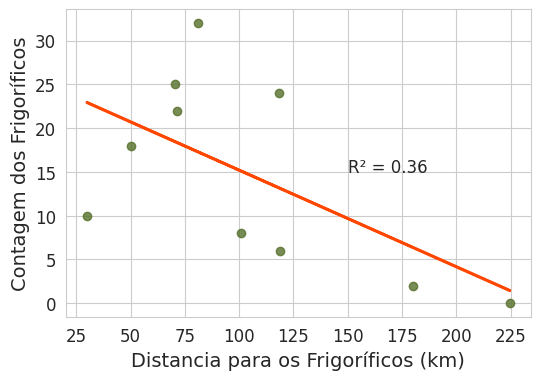

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# DataFrame fornecido
data = {
    'UF': ['BA', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PI', 'RO', 'TO'],
    'Distancia_Frigorificos_mean': [118.642869, 71.450757, 179.960083, 81.236029, 70.460904, 118.553748, 50.158913, 224.600239, 29.921395, 100.687256],
    'Contagem': [6, 22, 2, 32, 25, 24, 18, 0, 10, 8]
}

df = pd.DataFrame(data)

# Definindo estilo e cores
sns.set_palette(['#56702a'])
sns.set_style('whitegrid')

# Dispersograma com linha de tendência
plt.figure(figsize=(6, 4))
sns.regplot(x='Distancia_Frigorificos_mean', y='Contagem', data=df, scatter=True, ci=None, color='#56702a', line_kws={"color": "#ff4700"})

# Ajustando a linha de tendência e calculando o R²
slope, intercept, r_value, p_value, std_err = linregress(df['Distancia_Frigorificos_mean'], df['Contagem'])
plt.plot(df['Distancia_Frigorificos_mean'], slope * df['Distancia_Frigorificos_mean'] + intercept, color='#ff4700')
plt.text(150, 15, f'R² = {r_value**2:.2f}', fontsize=12)

plt.xlabel('Distancia para os Frigoríficos (km)', fontsize=14)
plt.ylabel('Contagem dos Frigoríficos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.title('Dispersograma com Linha de Tendência e R²', fontsize=14)
plt.grid(True)

plt.savefig(r'C:\Users\jp58\OneDrive\Área de Trabalho\Estágio\Resultados\Frigoríficos', dpi=300, bbox_inches='tight')  # Ajuste bbox_inches='tight'

plt.show()


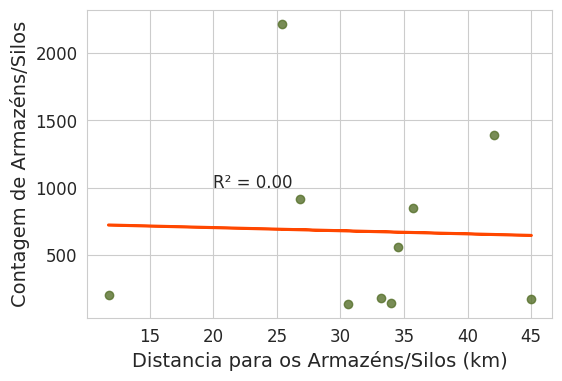

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Dados fornecidos
contagem_data = {
    'UF': ['BA', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PI', 'RO', 'TO'],
    'Contagem': [557, 914, 171, 2218, 846, 1387, 138, 136, 200, 176]
}

distancias_data = {
    'UF': ['BA', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PI', 'RO', 'TO'],
    'Distancia_Armazens_mean': [34.564467, 26.834507, 45.010544, 25.374647, 35.683856, 42.085846, 33.984925, 30.621008, 11.765826, 33.188503]
}

# Criando DataFrames
df_contagem = pd.DataFrame(contagem_data)
df_distancias = pd.DataFrame(distancias_data)

# Mesclando os DataFrames usando a coluna 'UF' como chave de junção
df = pd.merge(df_contagem, df_distancias, on='UF')

# Dispersograma com linha de tendência
plt.figure(figsize=(6, 4))
sns.regplot(x='Distancia_Armazens_mean', y='Contagem', data=df, scatter=True, ci=None, color='#56702a', line_kws={"color": "#ff4700"})

# Ajustando a linha de tendência e calculando o R²
slope, intercept, r_value, p_value, std_err = linregress(df['Distancia_Armazens_mean'], df['Contagem'])
plt.plot(df['Distancia_Armazens_mean'], slope * df['Distancia_Armazens_mean'] + intercept, color='#ff4700')
plt.text(20, 1000, f'R² = {r_value**2:.2f}', fontsize=12)

# Definindo rótulos dos eixos
plt.xlabel('Distancia para os Armazéns/Silos (km)', fontsize=14)
plt.ylabel('Contagem de Armazéns/Silos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Exibindo o gráfico
#plt.title('Dispersograma com Linha de Tendência e R²')
plt.grid(True)

plt.savefig(r'C:\Users\jp58\OneDrive\Área de Trabalho\Estágio\Resultados\Armazéns', dpi=300, bbox_inches='tight')  # Ajuste bbox_inches='tight'

plt.show()


## **2.5. Classificadores**

In [ ]:
import pandas as pd

dados3 = pd.read_excel('/content/drive/MyDrive/MapBiomas/dados_codificados_limpo_sem_vegetacao.xlsx')

In [ ]:
dados3_filtrado = dados3

In [ ]:
import pandas as pd
import numpy as np

# Criando uma nova coluna com a média das distâncias
dados3_filtrado['Media_Distancias'] = dados3_filtrado[['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias']].mean(axis=1)

# Calculating standard deviation across distances for each row
dados3_filtrado['Desvio_Padrao_Distancias'] = dados3_filtrado[['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias']].std(axis=1)

# Create normalized distance ratio features for all combinations without repeating
def calculate_normalized_distance_ratio(df, distance1, distance2):
    ratio_name = f'Normalized_Ratio_{distance1}_{distance2}'
    normalized_ratio = (df[distance1] - df[distance2]) / (df[distance1] + df[distance2])
    return ratio_name, normalized_ratio

distance_columns = ['Distancia_Cidades', 'Distancia_Armazens', 'Distancia_Frigorificos', 'menor_distancia_rodovias']

normalized_ratios = {}
for i, distance1 in enumerate(distance_columns):
    for distance2 in distance_columns[i+1:]:
        ratio_name, normalized_ratio = calculate_normalized_distance_ratio(dados3_filtrado, distance1, distance2)
        normalized_ratios[ratio_name] = normalized_ratio

# Adding normalized distance ratio features to the DataFrame
for ratio_name, normalized_ratio in normalized_ratios.items():
    dados3_filtrado[ratio_name] = normalized_ratio

In [ ]:
import numpy as np

# Limites para cada faixa
bins = [-np.inf, 20, 100, np.inf]

# Rótulos
labels = ['A', 'B', 'C']

# Criando a nova coluna categórica com base nas faixas de valores da coluna 'AreaAlerta'
dados3_filtrado['AreaCateg'] = pd.cut(dados3_filtrado['AreaAlerta'], bins=bins, labels=labels, right=False)

dados3_filtrado.head()

,AreaAlerta,Distancia_Cidades,Distancia_Armazens,Distancia_Frigorificos,menor_distancia_rodovias,mean,CITY_NEW,x,y,AMACROHA_0,...,MEAN_MONTH_TEXT_September,Media_Distancias,Desvio_Padrao_Distancias,Normalized_Ratio_Distancia_Cidades_Distancia_Armazens,Normalized_Ratio_Distancia_Cidades_Distancia_Frigorificos,Normalized_Ratio_Distancia_Cidades_menor_distancia_rodovias,Normalized_Ratio_Distancia_Armazens_Distancia_Frigorificos,Normalized_Ratio_Distancia_Armazens_menor_distancia_rodovias,Normalized_Ratio_Distancia_Frigorificos_menor_distancia_rodovias,AreaCateg
0,1.809,9.648438,32.843750,10.429688,0.797120,3.640478,Iguatemi,516991.515784,9.628543e+05,1,...,0,13.429749,13.659983,-0.545872,-0.038911,0.847376,0.517964,0.952610,0.857997,A
1,7.011,18.812500,3.767578,32.468750,1.544345,6.994717,Aral Moreira,444938.046448,1.054313e+06,1,...,0,14.148293,14.422352,0.666292,-0.266301,0.848273,-0.792055,0.418537,0.909191,A
2,7.779,11.992188,12.812500,28.125000,0.989545,3.922522,Coronel Sapucaia,441554.719115,1.018794e+06,1,...,0,13.479808,11.152677,-0.033071,-0.402142,0.847548,-0.374046,0.856609,0.932024,A
3,3.977,5.175781,6.187500,9.554688,0.150000,2.642468,Amambai,458166.775013,1.027162e+06,1,...,0,5.266992,3.891169,-0.089034,-0.297269,0.943670,-0.213896,0.952663,0.969087,A
4,9.353,32.218750,26.046875,35.437500,0.201246,3.940356,Amambai,483775.563014,9.993084e+05,1,...,0,23.476093,15.998299,0.105927,-0.047575,0.987585,-0.152732,0.984666,0.988706,A


In [ ]:
# Transformar a coluna "CITY_NEW" em variáveis dummy
dados3_filtrado = pd.get_dummies(dados3_filtrado, columns=['CITY_NEW'])
dados3_filtrado.head(5)

,AreaAlerta,Distancia_Cidades,Distancia_Armazens,Distancia_Frigorificos,menor_distancia_rodovias,mean,x,y,AMACROHA_0,MATOPIBAHA_0,...,CITY_NEW_Várzea Grande,CITY_NEW_Várzea da Palma,CITY_NEW_Wanderley,CITY_NEW_Wanderlândia,CITY_NEW_Água Boa,CITY_NEW_Água Branca,CITY_NEW_Água Clara,CITY_NEW_Água Doce do Maranhão,CITY_NEW_Água Fria de Goiás,CITY_NEW_Águas Lindas de Goiás
0,1.809,9.648438,32.843750,10.429688,0.797120,3.640478,516991.515784,9.628543e+05,1,1,...,False,False,False,False,False,False,False,False,False,False
1,7.011,18.812500,3.767578,32.468750,1.544345,6.994717,444938.046448,1.054313e+06,1,1,...,False,False,False,False,False,False,False,False,False,False
2,7.779,11.992188,12.812500,28.125000,0.989545,3.922522,441554.719115,1.018794e+06,1,1,...,False,False,False,False,False,False,False,False,False,False
3,3.977,5.175781,6.187500,9.554688,0.150000,2.642468,458166.775013,1.027162e+06,1,1,...,False,False,False,False,False,False,False,False,False,False
4,9.353,32.218750,26.046875,35.437500,0.201246,3.940356,483775.563014,9.993084e+05,1,1,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import time

# Iniciando o contador de tempo
start_time = time.time()

# Carregando os dados
df = dados3_filtrado

# Removendo a variável alvo e 'AreaAlerta'
X = df.drop(columns=['AreaCateg', 'AreaAlerta' ,'mean'])

# Normalizando as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo a variável alvo para one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['AreaCateg'])

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Construindo o modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Treinando o modelo
xgb_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = xgb_model.predict(X_test)

# Calculando as métricas de avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculando o tempo de treinamento ou execução
elapsed_time = time.time() - start_time

print("XGBoost Results:")
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Tempo de Treinamento ou Execução:", elapsed_time, "segundos")



XGBoost Results:
Accuracy: 0.8281457162699666
Confusion Matrix:
[[25790   204   111]
 [ 3840   209   109]
 [ 1091    89   235]]
Precision: 0.7695199726673374
Recall: 0.8281457162699666
F1 Score: 0.7709981667215898
Tempo de Treinamento ou Execução: 56.97118043899536 segundos


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import time

# Iniciando o contador de tempo
start_time = time.time()


# Carregando os dados
df = dados3_filtrado

# Removendo a variável alvo e 'AreaAlerta'
X = df.drop(columns=['AreaCateg', 'AreaAlerta' ,'mean'])

# Normalizando as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo a variável alvo para one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['AreaCateg'])

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Construindo o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Aqui você pode ajustar o número de vizinhos

# Treinando o modelo
knn_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = knn_model.predict(X_test)

# Calculando as métricas de avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculando o tempo de treinamento ou execução
elapsed_time = time.time() - start_time

print("K-Nearest Neighbors (KNN) Results:")
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Tempo de Treinamento ou Execução:", elapsed_time, "segundos")

K-Nearest Neighbors (KNN) Results:
Accuracy: 0.8146031946461266
Confusion Matrix:
[[25262   746    97]
 [ 3652   425    81]
 [ 1076   221   118]]
Precision: 0.7520383959920454
Recall: 0.8146031946461266
F1 Score: 0.7684954863799628
Tempo de Treinamento ou Execução: 180.62681102752686 segundos


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Carregando os dados
df = dados3_filtrado

# Removendo a variável alvo e 'AreaAlerta'
X = df.drop(columns=['AreaCateg', 'AreaAlerta' ,'mean'])

# Normalizando as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo a variável alvo para one-hot encoding
y = pd.get_dummies(df['AreaCateg'])

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Construindo o modelo da rede neural para classificação multiclasse
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Adding dropout regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout regularization
    tf.keras.layers.Dense(3, activation='softmax')  # Camada de saída para classificação multiclasse com função de ativação softmax
])

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinando o modelo com early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Avaliando o modelo
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)  # Convertendo as probabilidades em classes

# Calculando as métricas de avaliação do modelo
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), y_pred)
conf_matrix = confusion_matrix(np.argmax(y_test.values, axis=1), y_pred)
precision = precision_score(np.argmax(y_test.values, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(y_test.values, axis=1), y_pred, average='weighted')
f1 = f1_score(np.argmax(y_test.values, axis=1), y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 1/50
1617/1617 [==============================] - 10s 5ms/step - loss: 0.5690 - accuracy: 0.8185 - val_loss: 0.4947 - val_accuracy: 0.8244
Epoch 2/50
1617/1617 [==============================] - 6s 4ms/step - loss: 0.4972 - accuracy: 0.8256 - val_loss: 0.4896 - val_accuracy: 0.8244
Epoch 3/50
1617/1617 [==============================] - 8s 5ms/step - loss: 0.4883 - accuracy: 0.8257 - val_loss: 0.4879 - val_accuracy: 0.8249
Epoch 4/50
1617/1617 [==============================] - 6s 4ms/step - loss: 0.4825 - accuracy: 0.8259 - val_loss: 0.4868 - val_accuracy: 0.8252
Epoch 5/50
1617/1617 [==============================] - 8s 5ms/step - loss: 0.4785 - accuracy: 0.8265 - val_loss: 0.4870 - val_accuracy: 0.8255
Epoch 6/50
1617/1617 [==============================] - 6s 4ms/step - loss: 0.4749 - accuracy: 0.8270 - val_loss: 0.4868 - val_accuracy: 0.8257
Epoch 7/50
1617/1617 [==============================] - 8s 5ms/step - loss: 0.4724 - accuracy: 0.8264 - val_loss: 0.4873 - val_accuracy

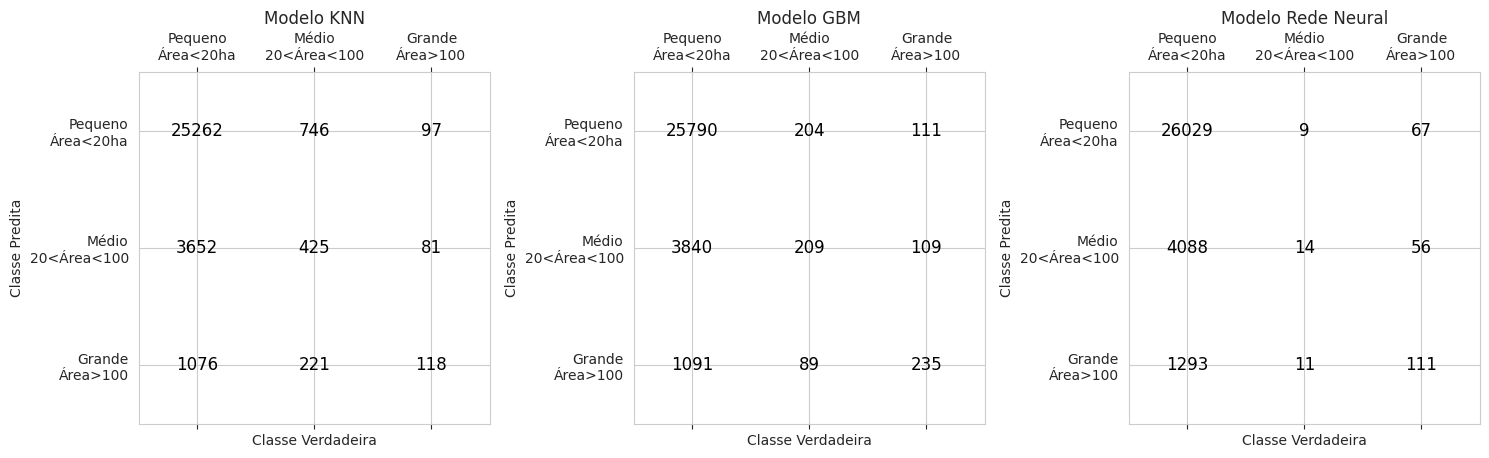

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Lista com os valores das Matrizes
confusion_matrices = [
    np.array([[25262, 746, 97], [3652, 425, 81], [1076, 221, 118]]),
    np.array([[25790, 204, 111], [3840, 209, 109], [1091, 89, 235]]),
    np.array([[26029, 9, 67], [4088, 14, 56], [1293, 11, 111]])
]

# Valores das classes
classes = ['Pequeno\nÁrea<20ha', 'Médio\n20<Área<100', 'Grande\nÁrea>100']

# 1 linha com 3 colunas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Model labels
model_labels = ['KNN', 'GBM', 'Rede Neural']

# Pefar todo limpo
cmap = mcolors.ListedColormap(['white'])

# Looping over confusion matrices and plotting
for i, ax in enumerate(axs):
    ax.matshow(confusion_matrices[i], cmap=cmap)  # Setting colormap to custom all white
    for (j, k), value in np.ndenumerate(confusion_matrices[i]):
        ax.text(k, j, f'{value}', ha='center', va='center', color='black', fontsize=12)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Classe Verdadeira')
    ax.set_ylabel('Classe Predita')
    ax.set_title(f'Modelo {model_labels[i]}')

plt.tight_layout()
plt.savefig(f'tal', dpi=300, bbox_inches='tight')  # Ajuste bbox_inches='tight'

plt.show()
